<a href="https://colab.research.google.com/github/Kunal-artist/AI_Chat_Bot/blob/main/notebook_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# STEP 1: Import Libraries and Load Data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style='whitegrid')

# Load datasets
trades = pd.read_csv('historical_data.csv')
sentiment = pd.read_csv('fear_greed_index.csv')

In [3]:
trades.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [4]:
sentiment.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [5]:
# STEP 2: Preprocessing and Merging
# Convert date columns
trades['time'] = pd.to_datetime(trades['Timestamp IST'], format="%d-%m-%Y %H:%M", dayfirst=True)
trades['date'] = trades['time'].dt.date

sentiment['Date'] = pd.to_datetime(sentiment['date'])
sentiment['date'] = sentiment['Date'].dt.date

# Merge based on date
merged_df = pd.merge(trades, sentiment[['date', 'classification']], on='date', how='inner')

# Clean classification strings
merged_df['classification'] = merged_df['classification'].str.capitalize().str.strip()

In [6]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211218 entries, 0 to 211217
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Account           211218 non-null  object        
 1   Coin              211218 non-null  object        
 2   Execution Price   211218 non-null  float64       
 3   Size Tokens       211218 non-null  float64       
 4   Size USD          211218 non-null  float64       
 5   Side              211218 non-null  object        
 6   Timestamp IST     211218 non-null  object        
 7   Start Position    211218 non-null  float64       
 8   Direction         211218 non-null  object        
 9   Closed PnL        211218 non-null  float64       
 10  Transaction Hash  211218 non-null  object        
 11  Order ID          211218 non-null  int64         
 12  Crossed           211218 non-null  bool          
 13  Fee               211218 non-null  float64       
 14  Trad

In [7]:
# STEP 3: Feature Engineering
# Profit
merged_df['profit'] = merged_df['Closed PnL']

# Volume (USD traded)
merged_df['volume'] = merged_df['Size USD']

# Buy/Sell encoding
merged_df['is_buy'] = merged_df['Side'].apply(
    lambda x: 1 if isinstance(x, str) and x.lower() == 'buy' else (
        0 if isinstance(x, str) and x.lower() == 'sell' else None
    )
)

# Leverage Proxy: Volume / Start Position
merged_df['leverage_proxy'] = merged_df['volume'] / merged_df['Start Position']

In [8]:
# STEP 4: Summary Stats by Sentiment
summary_stats = merged_df.groupby('classification')[
    ['profit', 'volume', 'is_buy', 'Fee', 'leverage_proxy']
].mean().round(2)

summary_stats.rename(columns={'is_buy': 'buy_ratio'}, inplace=True)

print("📊 Summary Stats by Sentiment")
print(summary_stats)

📊 Summary Stats by Sentiment
                profit   volume  buy_ratio   Fee  leverage_proxy
classification                                                  
Extreme fear     34.54  5349.73       0.51  1.12             inf
Extreme greed    67.89  3112.25       0.45  0.68             inf
Fear             54.29  7816.11       0.49  1.50             inf
Greed            42.74  5736.88       0.49  1.25             inf
Neutral          34.31  4782.73       0.50  1.04             inf


In [9]:
# STEP 5: Buy/Sell Volume Ratio by Sentiment
buy_volume = merged_df[merged_df['is_buy'] == 1].groupby('classification')['volume'].sum()
sell_volume = merged_df[merged_df['is_buy'] == 0].groupby('classification')['volume'].sum()

volume_ratio = (buy_volume / sell_volume).round(2).rename("buy_sell_volume_ratio").to_frame()

print("\n📈 Buy/Sell Volume Ratio by Sentiment")
print(volume_ratio)


📈 Buy/Sell Volume Ratio by Sentiment
                buy_sell_volume_ratio
classification                       
Extreme fear                     0.97
Extreme greed                    0.94
Fear                             1.04
Greed                            1.16
Neutral                          0.69


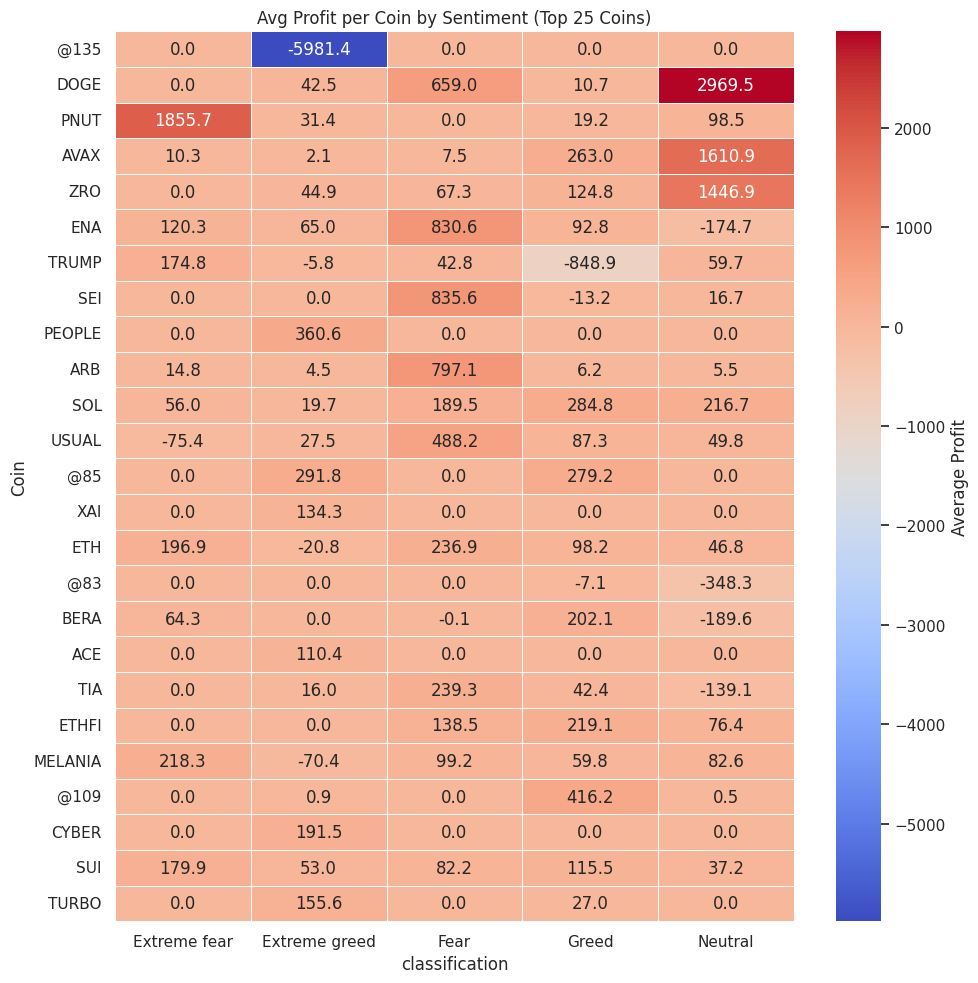

In [13]:
# STEP 6: Profit per Coin by Sentiment
profit_coin_sentiment = merged_df.groupby(['Coin', 'classification'])['profit'].mean().round(2).unstack()

# Filter: Keep only top N coins by mean absolute profit across sentiments
top_n = 25
top_coins = profit_coin_sentiment.abs().mean(axis=1).sort_values(ascending=False).head(top_n).index
filtered = profit_coin_sentiment.loc[top_coins]

# Plot
plt.figure(figsize=(10, 0.4 * len(filtered)))  # auto-adjust height

sns.heatmap(
    filtered.fillna(0),
    cmap='coolwarm',
    annot=True,
    fmt='.1f',
    linewidths=0.5,
    cbar_kws={'label': 'Average Profit'}
)

plt.title("Avg Profit per Coin by Sentiment (Top 25 Coins)")
plt.tight_layout()
plt.show()

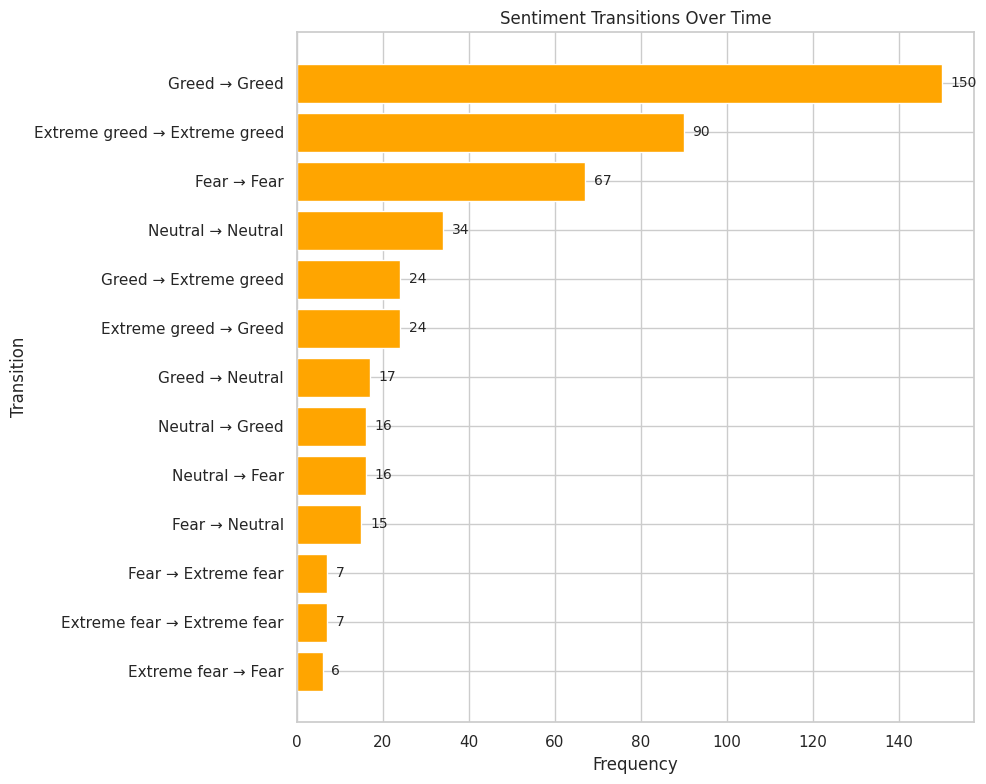

In [16]:
# STEP 7: Sentiment Transition Patterns
# One row per date
sentiment_over_time = merged_df[['date', 'classification']].drop_duplicates().sort_values('date')
sentiment_over_time['prev_sentiment'] = sentiment_over_time['classification'].shift(1)
sentiment_over_time['transition'] = sentiment_over_time['prev_sentiment'].astype(str) + ' → ' + sentiment_over_time['classification'].astype(str)

# Count transition occurrences
transition_counts = sentiment_over_time['transition'].value_counts()

# Filter rare transitions (e.g., less than 5 occurrences)
filtered_transitions = transition_counts[transition_counts > 5].sort_values()

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
bars = plt.barh(filtered_transitions.index, filtered_transitions.values, color='orange')

# Add value annotations
for bar in bars:
    width = bar.get_width()
    plt.text(width + 2, bar.get_y() + bar.get_height() / 2,
             str(int(width)), va='center', fontsize=10)

plt.title("Sentiment Transitions Over Time")
plt.xlabel("Frequency")
plt.ylabel("Transition")
plt.tight_layout()
plt.show()


/tmp/ipython-input-1894620605.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x='classification', y='profit', ci=None, color='skyblue')


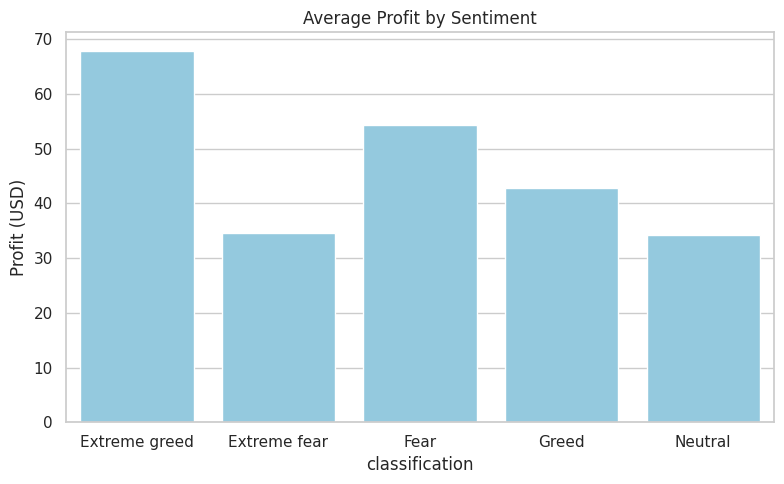

/tmp/ipython-input-1894620605.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x='classification', y='volume_clipped', ci=None, color='teal')


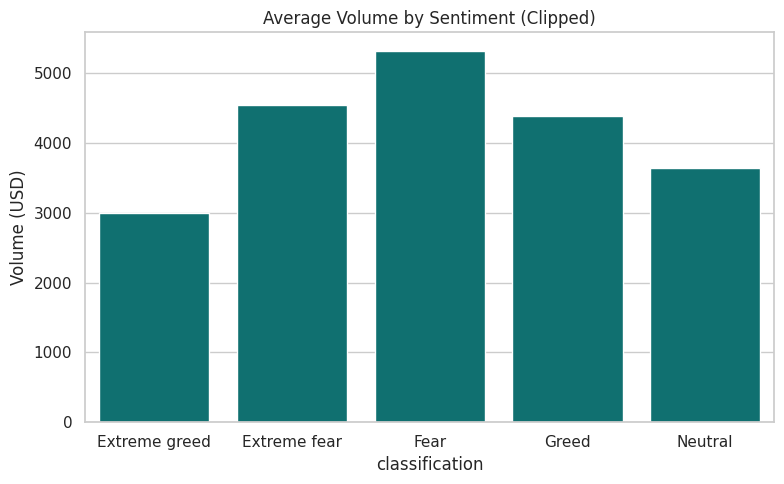

/tmp/ipython-input-1894620605.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x='classification', y='is_buy', ci=None, color='steelblue')


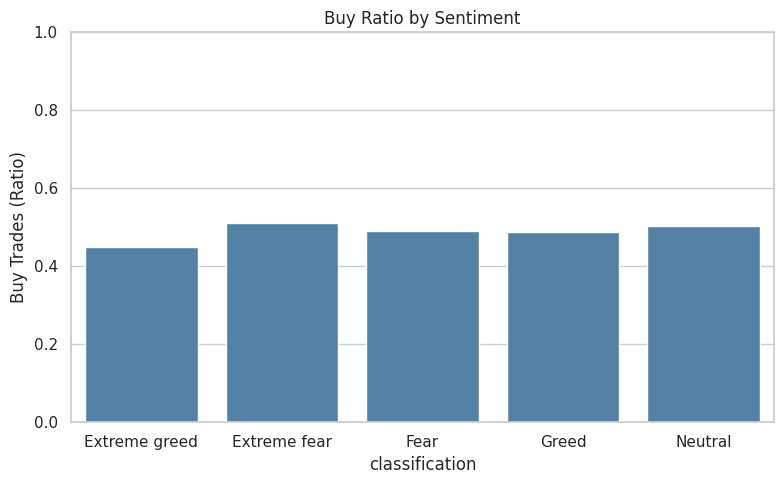

/tmp/ipython-input-1894620605.py:36: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=filtered_leverage_df, x='classification', y='leverage_proxy', ci=None, color='indianred')


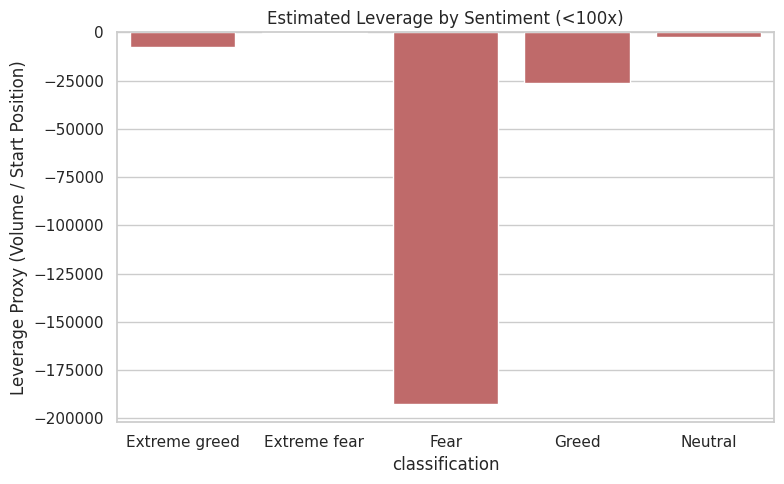

In [22]:
# STEP 8: Visualize Key Metrics
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')

plt.figure(figsize=(8, 5))
sns.barplot(data=merged_df, x='classification', y='profit', ci=None, color='skyblue')
plt.title("Average Profit by Sentiment")
plt.ylabel("Profit (USD)")
plt.tight_layout()
plt.show()

# Clip top 1% volume to remove outliers
merged_df['volume_clipped'] = merged_df['volume'].clip(upper=merged_df['volume'].quantile(0.99))

plt.figure(figsize=(8, 5))
sns.barplot(data=merged_df, x='classification', y='volume_clipped', ci=None, color='teal')
plt.title("Average Volume by Sentiment (Clipped)")
plt.ylabel("Volume (USD)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(data=merged_df, x='classification', y='is_buy', ci=None, color='steelblue')
plt.title("Buy Ratio by Sentiment")
plt.ylabel("Buy Trades (Ratio)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# Filter out unrealistic leverage
filtered_leverage_df = merged_df[merged_df['leverage_proxy'] < 100]

plt.figure(figsize=(8, 5))
sns.barplot(data=filtered_leverage_df, x='classification', y='leverage_proxy', ci=None, color='indianred')
plt.title("Estimated Leverage by Sentiment (<100x)")
plt.ylabel("Leverage Proxy (Volume / Start Position)")
plt.tight_layout()
plt.show()








In [19]:
merged_df.to_csv("cleaned_trader_sentiment_data.csv", index=False)